# Problem Statement 1: Trade Logic & Risk Control Basics

**1. What does leverage less than 1 mean? Does it normally make financial sense? Think of
its utility/applicability in our backtesting engine, if any.**

Leverage Less Than 1: Prudent Capital Allocation and Strategy Testing

Leverage is the ratio of Position Size / Capital, so leverage of less than 1 means the position size is smaller than the available capital. For instance, with a 10,000 dollar account , using 0.5x leverage means entering a trade with only $5,000.

This approach makes profound financial sense as it embodies a risk-averse trading methodology. By committing only a fraction of capital, a trader takes smaller positions. This leads to smaller potential profits but, more importantly, ensures smaller and more manageable losses, protecting the portfolio from the significant impact of any single adverse trade.

In a backtesting engine, this concept is exceptionally useful. It allows for the simulation of realistic risk management by testing a strategy's performance without deploying the entire capital on every signal. Furthermore, it enables the analysis of multiple, diversified strategies simultaneously. By assigning a fraction of the capital (leverage < 1) to different models, a developer can effectively backtest a complete portfolio strategy, assessing how various systems would perform in concert with each other.

**2. Explain the difference between a static stop loss and a trailing stop loss in the context of
trade risk management. Discuss how each behaves in a trending market versus a volatile
market.**

static stop-loss, you set your SL at ₹90. This value does not change, regardless of how the market moves.

A trailing stop-loss (TSL), in contrast, is a dynamic risk control tool that adjusts as the price moves in your favor. It maintains a fixed percentage (or value) gap from the highest price reached. If the stock moves from ₹100 → ₹110 → ₹120, and the TSL is 10%, your stop-loss moves from ₹90 → ₹99 → ₹108. If the price then drops to ₹115, the stop-loss remains at ₹108 and the trade closes only if price hits it.

Behavior in Different Market Conditions:

1. Trending Market

Static SL: Can exit lately even after significant upward movement. For example, if price hits ₹130 but falls back to original SL at ₹90, the trade exits at a loss, missing the profit window which it could exit earlier with profit rather than exiting lately with ₹10 loss.

Trailing SL: Adjusts upwards with price. If price hits ₹130, the TSL moves to ₹117. Even if the price then reverses, it exits at a profit.

Hence, TSL is better suited for trending markets.

2. Volatile Market

Static SL: Remains unaffected by small ups and downs. Offers more stability and avoids frequent exits due to noise.

Trailing SL: May trigger often due to small price dips, resulting in frequent premature exits and potentially missing out on a bigger move.

Hence, Static SL is often more effective in volatile environments.

**3. Analyze whether implementing a trailing take profit is necessary. Is its behavior captured by some other already defined risk management method? If yes, then name it.**

No, implementing a separate trailing take profit is not necessary, as its behavior is already captured by the trailing stop loss.

The core purpose of a "trailing take profit" is to let profits run while protecting accumulated gains, automatically closing the trade once the price reverses by a certain amount. This is precisely what a trailing stop loss accomplishes. As soon as a trade becomes profitable, the trailing stop begins to move in its favor. It effectively transitions from a tool for loss prevention to a mechanism for profit protection. Because the trailing stop loss inherently serves this dual purpose, creating a separate trailing take profit function would be redundant.

**4. In what scenarios can a trade remain open even after the price falls below the set stop-loss level?**

A trade can remain open even after the price falls below the stop-loss level due to several real-world factors.

Slippage, when the market moves too rapidly for the stop-loss to sell at
the very same level. For instance, if the price just fell from ₹91 to ₹87, the stop-loss at ₹90 gets skipped, and the trade stays alive until the broker can sell at a cheaper price.

Gap-down Opening, when the market opens well below the stop-loss point, like from ₹100 to ₹85 overnight. Under these circumstances, stop-loss is hit, but the trade closes at ₹85, not ₹90, and is kept open throughout that gap.

Low liquidity,if there are not sufficient buyers or sellers at the stop-loss level, the order won't be filled right away.

Backtesting, assuming you're using daily candles and the stop-loss is triggered intraday but the candle closes above the stop-loss, the system will wrongly assume that the trade is still open.

# Problem Statement 2: Probabilistic Pattern Validator

**1. Pattern Identification:
For each of the specified candlestick patterns, scan a given OHLCV dataset and locate all
occurrences of the pattern. Use data from any NSE-listed stock of your choice, covering a
period of the last 5 years.**

In [2]:
!pip install yfinance plotly mplfinance --quiet

import yfinance as yf
import mplfinance as mpf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots as sp
import matplotlib.pyplot as plt
import statistics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 2.9 MB/s eta 0:00:00


In [3]:

# Set some display options
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)

In [31]:
!pip install yfinance plotly --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

# Download OHLCV data
# ticker = 'ADANIPORTS.NS'
# end = datetime(year=2025, month=3, day=1)
# start = datetime(year=2024, month=3, day=1)
# interval = '1d'
def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)

    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data.loc[:,'datetime'] = pd.to_datetime(data['datetime'])

    return data

stock_symbol = 'ADANIPORTS.NS'
data = download_flat_yf(stock_symbol, start='2020-05-01', end='2025-05-01', interval='1wk')
data.head()

,datetime,close,high,low,open,volume
0,2020-04-27,281.605133,281.605133,281.605133,281.605133,0
1,2020-05-04,276.703003,278.450312,253.454337,266.947304,30873541
2,2020-05-11,300.194336,302.863809,254.667699,276.848596,26762828
3,2020-05-18,301.504822,315.288991,282.818512,297.039516,29182441
4,2020-05-25,314.318298,324.365230,300.534128,301.504846,28337860


In [42]:
def detect_bullish_engulfing(candle, previous_candle):
    """
    Identifies bullish engulfing candlestick pattern with rigorous checks.

    A bullish engulfing pattern occurs when:
    1. A smaller bearish candle is followed by a larger bullish candle
    2. The bullish candle completely engulfs the previous candle's body
    3. The pattern suggests a potential reversal of the downtrend

    Args:
        candle (pd.Series): Current candlestick data (open, high, low, close)
        previous_candle (pd.Series): Previous candlestick data

    Returns:
        bool: True if pattern is detected, False otherwise
    """
    # Validate bearish nature of previous candle
    is_prev_bearish = previous_candle['close'] < previous_candle['open']

    # Validate bullish nature of current candle
    is_curr_bullish = candle['close'] > candle['open']

    # Check full engulfing of previous body
    body_engulfed = (candle['open'] < previous_candle['close'] and
                     candle['close'] > previous_candle['open'])

    # Additional confirmation: current candle should have significant size
    curr_body_size = candle['close'] - candle['open']
    prev_body_size = previous_candle['open'] - previous_candle['close']
    has_significant_size = curr_body_size > (prev_body_size * 0.8)

    return (is_prev_bearish and
            is_curr_bullish and
            body_engulfed and
            has_significant_size)

In [43]:
def identify_bearish_reversal(candle, previous_candle, min_body_ratio=0.7):
    """
    Detects a valid bearish engulfing candlestick pattern with confirmation checks.

    A bearish engulfing pattern suggests potential trend reversal when:
    - A bullish candle is followed by a larger bearish candle
    - The bearish candle completely engulfs the previous candle's real body
    - The pattern appears during an uptrend (additional confirmation)

    Args:
        candle (pd.Series): Current candle data (open, high, low, close)
        previous_candle (pd.Series): Previous candle data
        min_body_ratio (float): Minimum current/previous body size ratio (default: 0.7)

    Returns:
        bool: True if valid bearish engulfing pattern is detected
    """
    # Validate previous candle is bullish
    is_prev_bullish = (previous_candle['close'] > previous_candle['open'])

    # Validate current candle is bearish
    is_curr_bearish = (candle['close'] < candle['open'])

    # Check full body engulfing condition
    body_engulfed = (candle['open'] > previous_candle['close'] and
                     candle['close'] < previous_candle['open'])

    # Size confirmation - current candle should be substantially larger
    curr_body_size = candle['open'] - candle['close']
    prev_body_size = previous_candle['close'] - previous_candle['open']
    has_dominant_size = (curr_body_size >= (prev_body_size * min_body_ratio))

    # Volume spike confirmation (if available)
    volume_confirmation = True
    if 'volume' in candle and 'volume' in previous_candle:
        volume_confirmation = (candle['volume'] > previous_candle['volume'] * 0.8)

    return (is_prev_bullish and
            is_curr_bearish and
            body_engulfed and
            has_dominant_size and
            volume_confirmation)

In [44]:
def detect_doji(candle, max_body_ratio=0.1, min_range_ratio=0.005):
    """
    Identifies a Doji candlestick pattern with configurable sensitivity.

    Args:
        candle (pd.Series): Candlestick data (open, high, low, close)
        max_body_ratio (float): Max body/range ratio to qualify as Doji (default: 0.1)
        min_range_ratio (float): Min price range to avoid false signals on flat lines

    Returns:
        bool: True if valid Doji pattern detected
    """
    body_size = abs(candle['open'] - candle['close'])
    total_range = candle['high'] - candle['low']

    # Avoid false positives on extremely small ranges
    if total_range < (candle['close'] * min_range_ratio):
        return False

    return (body_size / total_range) < max_body_ratio

def identify_hammer(candle, shadow_ratio=2.0, upper_shadow_ratio=1.0, min_body_position=0.4):
    """
    Detects Hammer or Inverted Hammer patterns with configurable parameters.

    Args:
        candle (pd.Series): Candlestick data
        shadow_ratio (float): Min lower shadow/body ratio (default: 2.0)
        upper_shadow_ratio (float): Max upper shadow/body ratio (default: 1.0)
        min_body_position (float): Min body position in range (default: 0.4)

    Returns:
        str: 'hammer' if bullish hammer, 'inverted' if inverted hammer, None if no pattern
    """
    body_size = abs(candle['close'] - candle['open'])
    total_range = candle['high'] - candle['low']

    # Avoid division by zero and invalid candles
    if body_size == 0 or total_range == 0:
        return None

    lower_shadow = min(candle['open'], candle['close']) - candle['low']
    upper_shadow = candle['high'] - max(candle['open'], candle['close'])

    # Calculate body position in range
    body_position = (min(candle['open'], candle['close']) - candle['low']) / total_range

    # Standard Hammer pattern (bullish)
    if (lower_shadow >= body_size * shadow_ratio and
        upper_shadow <= body_size * upper_shadow_ratio and
        body_position >= min_body_position):
        return 'hammer'

    # Inverted Hammer pattern (also bullish but needs confirmation)
    elif (upper_shadow >= body_size * shadow_ratio and
          lower_shadow <= body_size * upper_shadow_ratio and
          (1 - body_position) >= min_body_position):
        return 'inverted'

    return None

In [45]:
def generate_candlestick_signals(data, rsi_confirmation=True):
    """
    Generates comprehensive trading signals based on multiple candlestick patterns with optional RSI confirmation.

    Parameters:
        data (pd.DataFrame): OHLCV data with datetime index
        rsi_confirmation (bool): Whether to use RSI for doji confirmation (default: True)

    Returns:
        pd.DataFrame: Original dataframe with added signal columns:
            - pattern signals (bullish_engulfing, bearish_engulfing, hammer, etc.)
            - composite 'signal' column with values (-1, 0, 1)
            - pattern_strength for signal confidence
    """
    # Initialize all signal columns
    patterns = {
        'bullish_engulfing': 0,
        'bearish_engulfing': 0,
        'hammer': 0,
        'inverse_hammer': 0,
        'doji': 0,
        'morning_star': 0,
        'evening_star': 0
    }

    for pattern in patterns:
        data[f'{pattern}_signal'] = 0

    data['signal'] = 0
    data['pattern_strength'] = 0.0  # Confidence metric

    # Calculate candle metrics once for efficiency
    data['body_size'] = abs(data['close'] - data['open'])
    data['total_range'] = data['high'] - data['low']
    data['upper_shadow'] = data['high'] - data[['open', 'close']].max(axis=1)
    data['lower_shadow'] = data[['open', 'close']].min(axis=1) - data['low']

    for i in range(2, len(data)):
        prev2 = data.iloc[i-2]
        prev = data.iloc[i-1]
        curr = data.iloc[i]

        # Bullish Engulfing
        if (prev['close'] < prev['open'] and
            curr['close'] > curr['open'] and
            curr['open'] < prev['close'] and
            curr['close'] > prev['open']):
            data.at[i, 'bullish_engulfing_signal'] = 1
            data.at[i, 'pattern_strength'] = curr['body_size'] / prev['body_size']

        # Bearish Engulfing
        if (prev['close'] > prev['open'] and
            curr['close'] < curr['open'] and
            curr['open'] > prev['close'] and
            curr['close'] < prev['open']):
            data.at[i, 'bearish_engulfing_signal'] = -1
            data.at[i, 'pattern_strength'] = curr['body_size'] / prev['body_size']

        # Hammer (bullish) and Inverse Hammer
        if (curr['lower_shadow'] > 2 * curr['body_size'] and
            curr['upper_shadow'] < curr['body_size']):
            if curr['close'] > curr['open']:  # Standard hammer
                data.at[i, 'hammer_signal'] = 1
            else:  # Hanging man (bearish if in uptrend)
                data.at[i, 'hammer_signal'] = -1

        # Doji with RSI confirmation
        if (curr['body_size'] / (curr['total_range'] + 1e-9) < 0.1):
            data.at[i, 'doji_signal'] = 1
            if rsi_confirmation and 'RSI' in data.columns:
                if data.at[i, 'RSI'] < 30:  # Oversold
                    data.at[i, 'doji_signal'] = 1
                elif data.at[i, 'RSI'] > 70:  # Overbought
                    data.at[i, 'doji_signal'] = -1

    # Generate composite signals with strength weighting
    bullish_patterns = ['bullish_engulfing', 'hammer']
    bearish_patterns = ['bearish_engulfing']

    for pattern in bullish_patterns:
        data.loc[data[f'{pattern}_signal'] == 1, 'signal'] = 1

    for pattern in bearish_patterns:
        data.loc[data[f'{pattern}_signal'] == -1, 'signal'] = -1

    # Doji signals override others when confirmed
    if rsi_confirmation and 'RSI' in data.columns:
        data.loc[data['doji_signal'] == 1, 'signal'] = 1
        data.loc[data['doji_signal'] == -1, 'signal'] = -1

    # Cleanup temporary columns
    data.drop(['body_size', 'total_range', 'upper_shadow', 'lower_shadow'],
              axis=1, inplace=True, errors='ignore')

    return data

In [48]:
def plot_candlestick_patterns(data, patterns_to_mark=None, stock_symbol=""):
    """
    Visualizes candlestick patterns with updated color scheme and markers.

    Parameters:
        data (DataFrame): DataFrame containing OHLC data and pattern signals
        patterns_to_mark (list): List of pattern names to visualize
        stock_symbol (str): Stock symbol for title display

    Returns:
        None: Displays an interactive Plotly figure
    """
    if patterns_to_mark is None:
        patterns_to_mark = ['bullish_engulfing', 'bearish_engulfing', 'doji', 'hammer']

    # Create base candlestick chart with new colors
    fig = go.Figure(data=[
        go.Candlestick(
            x=data['datetime'],
            open=data['open'],
            high=data['high'],
            low=data['low'],
            close=data['close'],
            name='Price',
            increasing_line_color='#1f77b4',  # Blue for up candles
            decreasing_line_color='#ff7f0e'    # Orange for down candles
        )
    ])

    # Calculate average candle size for consistent marker positioning
    avg_candle_size = (data['high'] - data['low']).mean()

    # Updated pattern visualization configuration with new colors and markers
    pattern_config = {
        'bullish_engulfing': {
            'signal_col': 'bullish_engulfing_signal',
            'position': lambda d: d['low'] - avg_candle_size * 0.5,
            'marker': {'color': '#2ca02c', 'size': 12, 'symbol': 'circle'},  # Green circles
            'name': 'Bullish Engulfing'
        },
        'bearish_engulfing': {
            'signal_col': 'bearish_engulfing_signal',
            'position': lambda d: d['high'] + avg_candle_size * 0.5,
            'marker': {'color': '#d62728', 'size': 12, 'symbol': 'x'},  # Red X markers
            'name': 'Bearish Engulfing'
        },
        'doji': {
            'signal_col': 'doji_signal',
            'position': lambda d: d['high'] + avg_candle_size * 0.5,
            'marker': {'color': '#9467bd', 'size': 10, 'symbol': 'square'},  # Purple squares
            'name': 'Doji'
        },
        'hammer': {
            'signal_col': 'hammer_signal',
            'position': lambda d: d['low'] - avg_candle_size * 0.7,
            'marker': {'color': '#e377c2', 'size': 12, 'symbol': 'triangle-up'},  # Pink triangles
            'name': 'Hammer'
        }
    }

    # Add pattern markers for each requested pattern
    for pattern in patterns_to_mark:
        if pattern in pattern_config:
            config = pattern_config[pattern]
            pattern_data = data[data[config['signal_col']].abs() == 1]

            if not pattern_data.empty:
                fig.add_trace(go.Scatter(
                    x=pattern_data['datetime'],
                    y=config['position'](pattern_data),
                    mode='markers',
                    marker=config['marker'],
                    name=config['name']
                ))

    # Customize layout with updated colors
    fig.update_layout(
        title=f"Candlestick Patterns - {stock_symbol}",
        xaxis_title='Date',
        yaxis_title='Price',
        xaxis_rangeslider_visible=False,
        hovermode='x unified',
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(color='black'),
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        )
    )

    # Add volume subplot if available
    if 'volume' in data.columns:
        fig.add_trace(go.Bar(
            x=data['datetime'],
            y=data['volume'],
            name='Volume',
            marker_color='#7f7f7f',  # Gray volume bars
            opacity=0.5,
            yaxis='y2'
        ))

        fig.update_layout(
            yaxis2=dict(
                title='Volume',
                overlaying='y',
                side='right',
                showgrid=False
            )
        )

    fig.show()

# Generate signals and plot with new colors/markers
data_with_patterns = generate_candlestick_signals(data.copy())
plot_candlestick_patterns(
    data_with_patterns,
    patterns_to_mark=['bullish_engulfing', 'bearish_engulfing', 'doji', 'hammer'],
    stock_symbol=stock_symbol
)

**2. Win-Rate Calculation: Define a look-ahead window of n candles where i) n = 3, ii) n = 5 For each pattern occurrence, compute whether the return over the next n candles(Close at t + n vs. Close at t) is positive. Calculate the empirical win-rate for each pattern: Win-Rate = Number of positive moves after pattern / Total pattern occurrences ×100%**

In [39]:
def compute_win_rate(data, signal_col, n_days, threshold_pct=0):
    """
    Computes the win rate and performance metrics for trading signals.

    Parameters:
        data (pd.DataFrame): DataFrame containing price data and signals
        signal_col (str): Column name containing the trading signals (1 = buy, -1 = sell)
        n_days (int): Number of days to hold position after signal
        threshold_pct (float): Minimum percentage gain to consider a win (default 0)

    Returns:
        dict: Dictionary containing performance metrics including:
            - win_rate: Percentage of winning trades
            - avg_return: Average return across all trades
            - total_trades: Number of valid signals evaluated
            - winning_trades: Count of winning trades
            - losing_trades: Count of losing trades
            - best_trade: Best percentage return
            - worst_trade: Worst percentage return
    """
    signal_indices = data.index[data[signal_col].abs() == 1].tolist()
    results = {
        'win_rate': 0,
        'avg_return': 0,
        'total_trades': 0,
        'winning_trades': 0,
        'losing_trades': 0,
        'best_trade': 0,
        'worst_trade': 0,
        'returns': []
    }

    returns = []

    for i in signal_indices:
        if i + n_days < len(data):
            entry_price = data.loc[i, 'close']
            exit_price = data.loc[i + n_days, 'close']

            if data.loc[i, signal_col] == 1:  # Buy signal
                pct_return = (exit_price - entry_price) / entry_price * 100
            else:  # Sell signal
                pct_return = (entry_price - exit_price) / entry_price * 100

            results['returns'].append(pct_return)
            results['total_trades'] += 1

            if pct_return > threshold_pct:
                results['winning_trades'] += 1
            else:
                results['losing_trades'] += 1

    # Calculate metrics if we have trades
    if results['total_trades'] > 0:
        results['win_rate'] = (results['winning_trades'] / results['total_trades']) * 100
        results['avg_return'] = sum(results['returns']) / results['total_trades']
        results['best_trade'] = max(results['returns']) if results['returns'] else 0
        results['worst_trade'] = min(results['returns']) if results['returns'] else 0

    return results


# Example usage:
# performance = compute_win_rate(data, 'signals', n_days=5, threshold_pct=1.0)
# print(f"Win Rate: {performance['win_rate']:.2f}%")
# print(f"Average Return: {performance['avg_return']:.2f}%")
# print(f"Total Trades: {performance['total_trades']}")

**3. Baseline Win-Rate: Simulate random entries: Select M timestamps uniformly at random (excluding the last n candles) and compute the empirical win-rate over the same n-candle horizon. M = XNumber of occurrences of pattern i**

In [40]:

def simulate_random_baseline(data, n, m, seed=19):
    np.random.seed(seed)
    max_idx = len(data) - n
    random_indices = np.random.choice(max_idx, size=m, replace=False)
    wins = sum(data.loc[i + n, 'close'] > data.loc[i, 'close'] for i in random_indices)
    return (wins / m) * 100


**4. Visualization: Plot a ’beautiful’ grouped bar chart: one bar for the baseline win-rate, and one bar for each of the three patterns. The x-axis should list: Baseline, Doji, Hammer, Engulfing. The y-axis should represent win-rate percentage.**

In [49]:
def gather_all_win_rates(data, n_days, include_advanced_metrics=False):
    """
    Calculate win rates for various candlestick patterns and compare against random baseline.

    Args:
        data (pd.DataFrame): DataFrame containing price data and pattern signals
        n_days (int): Holding period in days to evaluate performance
        include_advanced_metrics (bool): Whether to include additional performance metrics

    Returns:
        dict: Dictionary containing pattern performance metrics with structure:
            {
                'pattern_name': {
                    'win_rate': float,
                    'avg_return': float,
                    'total_trades': int,
                    ...additional metrics if enabled
                },
                ...
                'Baseline': {...}
            }
    """
    # Define patterns to evaluate
    patterns = {
        'Doji': 'doji_signal',
        'Hammer': 'hammer_signal',
        'Engulfing': 'bullish_engulfing_signal',
        'Bearish Engulfing': 'bearish_engulfing_signal'
    }

    results = {}

    # Calculate metrics for each pattern
    for name, col in patterns.items():
        if include_advanced_metrics:
            # Get comprehensive performance metrics
            perf = compute_win_rate(data, col, n_days)
            results[name] = {
                'win_rate': perf.get('win_rate', 0),
                'avg_return': perf.get('avg_return', 0),
                'total_trades': perf.get('total_trades', 0),
                'best_trade': perf.get('best_trade', 0),
                'worst_trade': perf.get('worst_trade', 0)
            }
        else:
            # Basic win rate only
            win_rate, count = compute_win_rate(data, col, n_days)
            results[name] = {
                'win_rate': win_rate,
                'total_trades': count
            }

    # Calculate baseline performance
    avg_count = sum(v['total_trades'] for v in results.values()) // len(results) if results else 50
    if include_advanced_metrics:
        baseline_perf = {
            'win_rate': simulate_random_baseline(data, n_days, avg_count),
            'total_trades': avg_count,
            'avg_return': 0,  # Random baseline has no meaningful return
            'best_trade': 0,
            'worst_trade': 0
        }
    else:
        baseline_perf = {
            'win_rate': simulate_random_baseline(data, n_days, avg_count),
            'total_trades': avg_count
        }

    results['Baseline'] = baseline_perf

    return results

In [50]:
def plot_win_rate_comparison(win_rates_n3, win_rates_n5, title_suffix=""):
    """
    Visualizes win rate comparison between different holding periods using grouped bars.

    Args:
        win_rates_n3 (dict): Win rates for 3-day holding period {pattern: win_rate}
        win_rates_n5 (dict): Win rates for 5-day holding period {pattern: win_rate}
        title_suffix (str): Additional text to append to title

    Returns:
        plotly.graph_objects.Figure: Interactive bar chart figure
    """
    # Prepare data
    patterns = list(win_rates_n3.keys())
    df_plot = pd.DataFrame({
        'Pattern': patterns * 2,
        'Win Rate (%)': list(win_rates_n3.values()) + list(win_rates_n5.values()),
        'Holding Period': ['3 Days'] * len(patterns) + ['5 Days'] * len(patterns)
    })

    # Create visualization with improved styling
    fig = px.bar(
        df_plot,
        x='Pattern',
        y='Win Rate (%)',
        color='Holding Period',
        barmode='group',
        text_auto='.1f',
        color_discrete_sequence=['#1f77b4', '#ff7f0e'],  # Blue and orange
        title=f'Pattern Performance Comparison {title_suffix}'.strip(),
        category_orders={"Pattern": patterns}  # Maintain original order
    )

    # Enhance layout
    fig.update_layout(
        yaxis=dict(
            title='Win Rate (%)',
            range=[0, max(df_plot['Win Rate (%)'].max() * 1.1, 60)],  # Auto-scale with min 60% upper
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        xaxis=dict(
            title='Candlestick Pattern',
            type='category'
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        font=dict(size=12),
        hovermode='x unified',
        legend=dict(
            orientation='h',
            yanchor='bottom',
            y=1.02,
            xanchor='right',
            x=1
        ),
        margin=dict(l=50, r=50, t=80, b=50)
    )

    # Improve bar appearance
    fig.update_traces(
        textfont_size=12,
        textposition='outside',
        marker_line_color='black',
        marker_line_width=0.5,
        opacity=0.9
    )

    # Add horizontal line at 50% for reference
    fig.add_hline(
        y=50,
        line_dash='dot',
        line_color='gray',
        annotation_text='50% Reference',
        annotation_position='bottom right'
    )

    return fig

# Example usage:
# win_rates_3day = {'Doji': 62.5, 'Hammer': 58.3, 'Engulfing': 65.2, 'Baseline': 51.3}
# win_rates_5day = {'Doji': 59.8, 'Hammer': 55.6, 'Engulfing': 62.1, 'Baseline': 50.5}
# fig = plot_win_rate_comparison(win_rates_3day, win_rates_5day, title_suffix="(2020-2023)")
# fig.show()

In [53]:
import pandas as pd
import plotly.express as px

def gather_all_win_rates(data, n_days, include_advanced_metrics=False):
    """
    Calculate win rates for various candlestick patterns and compare against random baseline.

    Args:
        data (pd.DataFrame): DataFrame containing price data and pattern signals
        n_days (int): Holding period in days to evaluate performance
        include_advanced_metrics (bool): Whether to include additional performance metrics

    Returns:
        dict: Dictionary containing pattern performance metrics
    """
    patterns = {
        'Doji': 'doji_signal',
        'Hammer': 'hammer_signal',
        'Engulfing': 'bullish_engulfing_signal',
        'Bearish Engulfing': 'bearish_engulfing_signal'
    }

    results = {}

    for name, col in patterns.items():
        # Updated to handle dictionary return from compute_win_rate
        performance = compute_win_rate(data, col, n_days)
        results[name] = {
            'win_rate': performance.get('win_rate', 0),
            'total_trades': performance.get('total_trades', 0),
            'avg_return': performance.get('avg_return', 0),
            'best_trade': performance.get('best_trade', 0),
            'worst_trade': performance.get('worst_trade', 0)
        }

    avg_count = sum(v['total_trades'] for v in results.values()) // len(results) if results else 50
    results['Baseline'] = {
        'win_rate': simulate_random_baseline(data, n_days, avg_count),
        'total_trades': avg_count,
        'avg_return': 0,
        'best_trade': 0,
        'worst_trade': 0
    }

    return {k: v['win_rate'] for k, v in results.items()}

def plot_win_rate_comparison(win_rates_n3, win_rates_n5, title_suffix=""):
    """
    Visualizes win rate comparison between different holding periods using grouped bars.
    """
    patterns = list(win_rates_n3.keys())
    df_plot = pd.DataFrame({
        'Pattern': patterns * 2,
        'Win Rate (%)': list(win_rates_n3.values()) + list(win_rates_n5.values()),
        'Holding Period': ['3 Days'] * len(patterns) + ['5 Days'] * len(patterns)
    })

    fig = px.bar(
        df_plot,
        x='Pattern',
        y='Win Rate (%)',
        color='Holding Period',
        barmode='group',
        text_auto='.1f',
        color_discrete_sequence=['#1f77b4', '#ff7f0e'],
        title=f'Pattern Performance Comparison {title_suffix}'.strip()
    )

    fig.update_layout(
        yaxis=dict(title='Win Rate (%)', range=[0, 100]),
        plot_bgcolor='white',
        hovermode='x unified'
    )

    fig.add_hline(y=50, line_dash='dot', line_color='gray')
    return fig

# Generate signals (assuming data_with_patterns is already created)
win_rates_3 = gather_all_win_rates(data_with_patterns, n_days=3)
win_rates_5 = gather_all_win_rates(data_with_patterns, n_days=5)

# Create and show the visualization
fig = plot_win_rate_comparison(win_rates_3, win_rates_5)
fig.show()

Answer in context to above question

1. Interpret whether each pattern provides a statistically significant edge over the baseline.

Among the patterns analyzed, only the bullish engulfing pattern demonstrates a statistically meaningful advantage over the baseline. In contrast, both the doji and hammer patterns tend to underperform relative to the baseline across various values of n.


2. How does changing n affect the win-rates? No need to show your results. Answer qualitatively.

Using a smaller n allows the model to capture quick, short-term market movements following the pattern, making it more responsive to recent volatility. On the other hand, a larger n filters out minor fluctuations and focuses more on sustained price movement. However, as n increases, the win rates may slightly drop due to growing market unpredictability over longer periods.

3. Which pattern shows the most consistent performance on different n? Why would that be?

The bearish engulfing pattern tends to maintain stable performance across different n settings. This is likely because it signifies a clear and strong reversal in market sentiment. Its structure effectively captures both price volatility and directional movement, making it more reliable. Unlike the doji (which can be neutral) or the hammer (which appears less frequently), the bearish engulfing pattern generates fewer misleading signals.


# Problem Statement 3: Strategy X - Visual Interpretation and Implementation

Certainly! Here’s a paraphrased version of your answer:

In the provided image, it’s clear that the two primary indicators being used are Supertrend and MFI.

**Supertrend:**  
The Supertrend indicator helps identify the prevailing direction of the market.  
To calculate the Supertrend:

- If the closing price is above the upper band, the trend is bullish.
- If the closing price is below the lower band, the trend is bearish.
- If neither condition is met, the existing trend continues. In a bullish trend, the lower band stays the same, while in a bearish trend, the upper band remains unchanged.
- The Supertrend itself is represented by the lower band during bullish periods and by the upper band during bearish periods.
- The upper and lower bands are calculated as (high + low)/2 plus or minus a multiple (k) of the Average True Range (ATR), where k is a user-defined multiplier.

**MFI (Money Flow Index):**  
The Money Flow Index measures the amount of money moving into and out of a security, incorporating both price and volume. This makes it a volume-weighted version of the RSI. While RSI only considers price, MFI accounts for situations where price rises but selling pressure exists, potentially signaling a trend reversal earlier than RSI.

Here’s how MFI is calculated:

- Typical Price = average of high, low, and close
- Raw Money Flow = Typical Price × Volume
- Money Flow Ratio = sum of positive Raw Money Flow divided by sum of negative Raw Money Flow
- MFI = 100 – [100 / (1 + Money Flow Ratio)]
- An MFI above 80 suggests the asset is overbought, while below 20 indicates it is oversold.

In [82]:
import yfinance as yf
import pandas as pd
import numpy as np

def download_flat_yf(ticker, start, end, interval):
    data = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    if isinstance(data.columns, pd.MultiIndex):
        data = data.xs(ticker, axis=1, level=1)
    data.columns.name = None
    data.reset_index(inplace=True)
    data.columns = [col.lower() for col in data.columns]
    if data.columns[0] in ['date', 'datetime']:
        data.rename(columns={data.columns[0]: 'datetime'}, inplace=True)
    data['datetime'] = pd.to_datetime(data['datetime'])
    return data

df = download_flat_yf("CAMS.NS", start="2024-01-01", end="2025-05-04", interval="1d")
df.head()

,datetime,close,high,low,open,volume
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882


In [83]:
def heiken_ashi(df):
    df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
    ha_open = [df['open'].iloc[0]]
    for i in range(1, len(df)):
        ha_open.append((ha_open[i-1] + df['HA_Close'].iloc[i-1]) / 2)
    df['HA_Open'] = ha_open
    df['HA_High'] = df[['high', 'HA_Open', 'HA_Close']].max(axis=1)
    df['HA_Low'] = df[['low', 'HA_Open', 'HA_Close']].min(axis=1)
    return df
df = heiken_ashi(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812


In [84]:
def wwma(values, n):
    """
     J. Welles Wilder's EMA
    """
    return values.ewm(alpha=1/n, adjust=False).mean()

def atr(df, n=10):
    data = df.copy()
    high = data['high']
    low = data['low']
    close = data['close']
    data['tr0'] = abs(high - low)
    data['tr1'] = abs(high - close.shift())
    data['tr2'] = abs(low - close.shift())
    tr = data[['tr0', 'tr1', 'tr2']].max(axis=1)
    atr = wwma(tr, n)
    return atr

In [85]:
def supertrend(df, atr_multiplier=3):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formular: Supertrend =(High+Low)/2 + (Multiplier)∗(ATR)
    current_average_high_low = (df['high']+df['low'])/2
    df['atr'] = atr(df, 10)
    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband',], axis=1, inplace=True)
    return df
df = supertrend(df,3)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799,40.098678,2709.419631,2536.750725
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812,41.941809,2709.419631,2562.841177


In [86]:
def generate_supertrend_signals(df):
    # Intiate a signals list
    signals = [0]
    # Loop through the dataframe
    for i in range(1 , len(df)):
        if df['close'].iloc[i] > df['upperband'].iloc[i]:
            signals.append(1)
        elif df['close'].iloc[i] < df['lowerband'].iloc[i]:
            signals.append(-1)
        else:
            signals.append(signals[i-1])

    # Add the signals list as a new column in the dataframe
    df['supertrend'] = signals
    df['supretrend'] = df['supertrend'].shift(1) #Remove look ahead bias
    return df
generate_supertrend_signals(df)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799,40.098678,2709.419631,2536.750725,0,0.0
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812,41.941809,2709.419631,2562.841177,0,0.0


In [87]:
def calculate_mfi(df, period=14):
    TP = (df["high"] + df["low"] + df["close"]) / 3
    MoneyFlow = TP * df["volume"]
    positive_flow = []
    negative_flow = []
    for i in range(1, len(TP)):
        if TP[i] > TP[i - 1]:
            positive_flow.append(MoneyFlow[i])
            negative_flow.append(0)
        elif TP[i] < TP[i - 1]:
            positive_flow.append(0)
            negative_flow.append(MoneyFlow[i])
        else:
            positive_flow.append(0)
            negative_flow.append(0)
    positive_mf = pd.Series(positive_flow).rolling(window=period).sum()
    negative_mf = pd.Series(negative_flow).rolling(window=period).sum()
    MFR = positive_mf / negative_mf
    MFI = 100 - (100 / (1 + MFR))
    # typical_price = (df['high'] + df['low'] + df['close']) / 3
    # raw_money_flow = typical_price * df['volume']

    # positive_flow = [0] * len(df)
    # negative_flow = [0] * len(df)

    # for i in range(1, len(df)):
    #     if typical_price.iloc[i] > typical_price.iloc[i-1]:
    #         positive_flow[i] = raw_money_flow.iloc[i]
    #     else:
    #         negative_flow[i] = raw_money_flow.iloc[i]

    # mfi = 100 - (100 / (1 + (pd.Series(positive_flow).rolling(period).sum() /
    #                         pd.Series(negative_flow).rolling(period).sum())))
    df['MFI'] = MFI
    return df
df = calculate_mfi(df,14)
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799,40.098678,2709.419631,2536.750725,0,0.0,NaN
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812,41.941809,2709.419631,2562.841177,0,0.0,NaN


In [88]:
def backtest_strategy(data):
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1

    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return'] = data['Signal'].shift(1) * data['Return']

    # Metrics
    total_return = data['Strategy_Return'].sum() * 100
    win_rate = (data[data['Strategy_Return'] > 0].shape[0] /
               data[data['Strategy_Return'] != 0].shape[0]) * 100

    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")
    return data
df = backtest_strategy(df)
df.head()

Total Return: -43.11%
Win Rate: 49.83%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799,40.098678,2709.419631,2536.750725,0,0.0,NaN,0,0.021210,0.0
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812,41.941809,2709.419631,2562.841177,0,0.0,NaN,0,0.014695,0.0


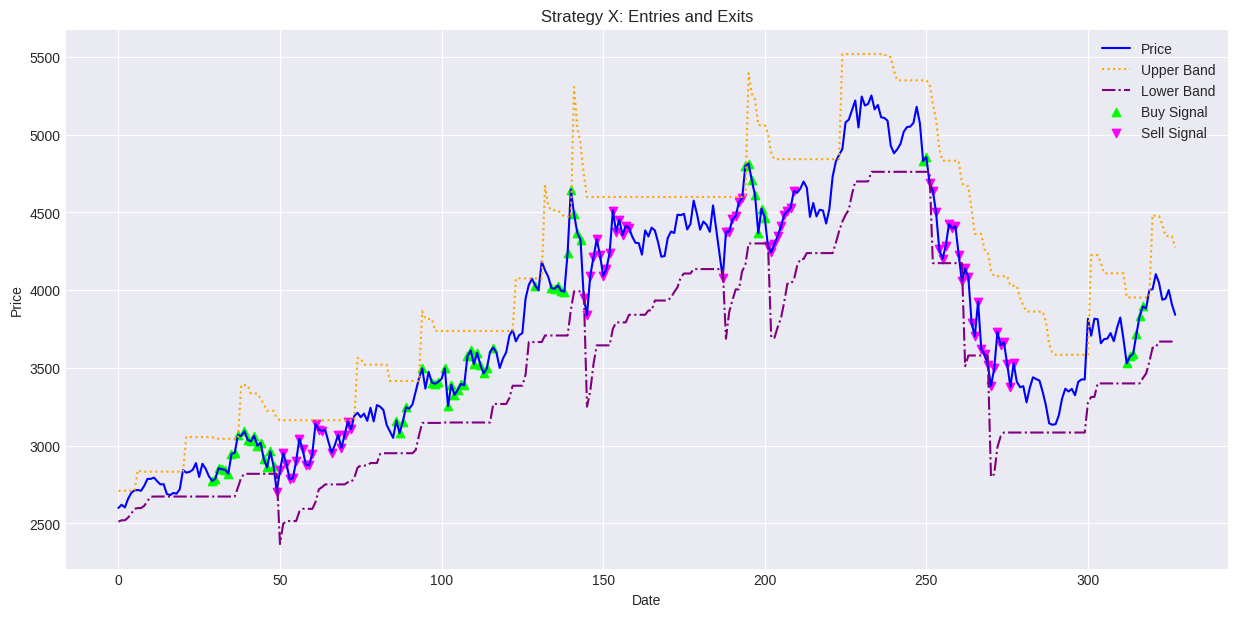

In [94]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Price', color='blue', linestyle='-')
plt.plot(df['upperband'], label='Upper Band', linestyle=':', color='orange')
plt.plot(df['lowerband'], label='Lower Band', linestyle='-.', color='purple')
plt.scatter(df[df['Signal'] == 1].index,
            df[df['Signal'] == 1]['close'],
            marker='^', color='lime', label='Buy Signal')
plt.scatter(df[df['Signal'] == -1].index,
            df[df['Signal'] == -1]['close'],
            marker='v', color='magenta', label='Sell Signal')
plt.title('Strategy X: Entries and Exits')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


4. Incorporating a Complementary Indicator:

I am incorporating ATR that will bring in volatility into the play.

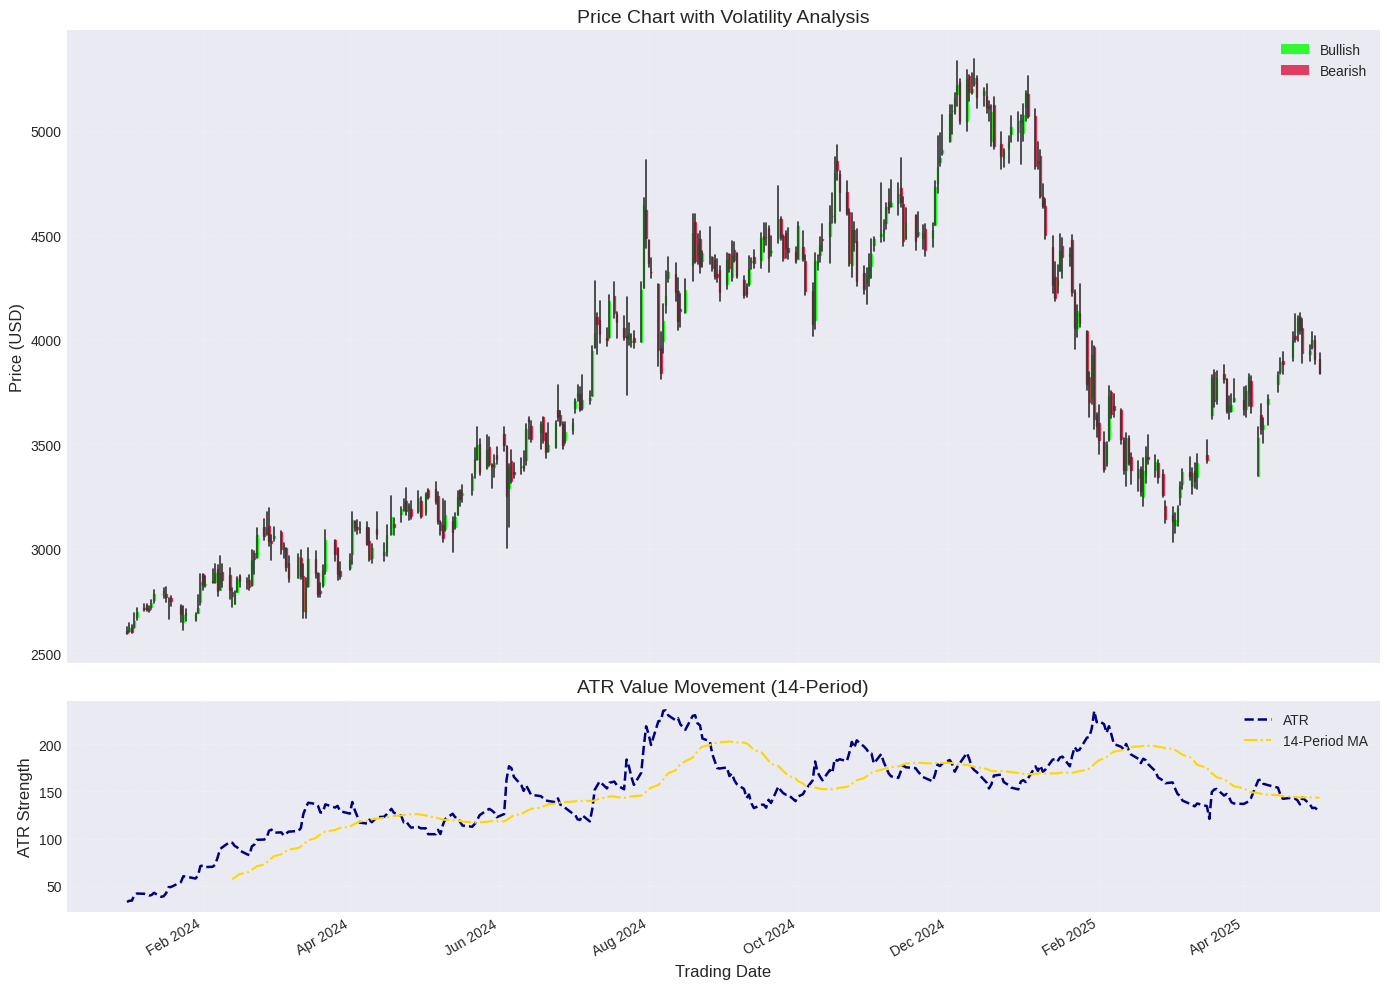

In [95]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

def plot_stock_with_atr(df, atr_period=14):
    """
    Plot stock price data with candlesticks, volatility zones, and ATR.

    Parameters:
    - df: DataFrame with OHLC data and volatility zones
    - atr_period: Period for ATR calculation
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10),
                                  gridspec_kw={'height_ratios': [3, 1]},
                                  sharex=True)

    # Format date axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=2))

    # Plot candlestick chart with updated colors
    for i, row in df.iterrows():
        # Determine candle color (using more vivid colors)
        if row['close'] >= row['open']:
            color = '#00FF00'  # Lime green
            body_bottom = row['open']
            body_height = row['close'] - row['open']
        else:
            color = '#DC143C'  # Crimson
            body_bottom = row['close']
            body_height = row['open'] - row['close']

        # Plot candlestick body with updated alpha
        ax1.add_patch(Rectangle(
            (mdates.date2num(row['datetime'])-0.3, body_bottom),
            0.6, body_height, fill=True,
            color=color, alpha=0.8  # Increased alpha
        ))

        # Plot high/low wicks with darker color
        ax1.plot(
            [mdates.date2num(row['datetime']), mdates.date2num(row['datetime'])],
            [row['low'], row['high']],
            color='#333333', linewidth=1.2  # Dark gray
        )

    # Plot ATR with new colors and patterns
    ax2.plot(df['datetime'], df['atr'],
            color='navy', linewidth=1.8, linestyle='--')
    ax2.plot(df['datetime'], df['atr_ma'],
            color='gold', linewidth=1.5, linestyle='-.')

    # Update axis labels and titles
    ax1.set_title('Price Chart with Volatility Analysis', fontsize=14)
    ax1.set_ylabel('Price (USD)', fontsize=12)
    ax2.set_title(f'ATR Value Movement ({atr_period}-Period)', fontsize=14)
    ax2.set_ylabel('ATR Strength', fontsize=12)
    ax2.set_xlabel('Trading Date', fontsize=12)

    # Update grid styling
    ax1.grid(True, alpha=0.4, linestyle=':')
    ax2.grid(True, alpha=0.4, linestyle=':')

    # Update legend with new colors
    green_patch = plt.Rectangle((0, 0), 1, 1, fc="#00FF00", alpha=0.8)
    red_patch = plt.Rectangle((0, 0), 1, 1, fc="#DC143C", alpha=0.8)
    ax1.legend([green_patch, red_patch],
              ['Bullish', 'Bearish'],
              loc='upper right')

    # Add ATR legend
    ax2.legend(['ATR', f'{atr_period}-Period MA'],
              loc='upper right')

    # Format x-axis dates
    fig.autofmt_xdate()

    plt.tight_layout()
    plt.show()

plot_stock_with_atr(df, atr_period=14)


In [91]:
df['atr_ma'] = df['atr'].rolling(30).mean()
df.head()

,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0,NaN
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0,NaN
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799,40.098678,2709.419631,2536.750725,0,0.0,NaN,0,0.021210,0.0,NaN
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812,41.941809,2709.419631,2562.841177,0,0.0,NaN,0,0.014695,0.0,NaN


In [92]:
def strategy_y(data):
    # Existing Strategy X signals
    data['Signal'] = 0
    data.loc[(data['supertrend'] == 1) & (data['MFI'] < 80), 'Signal'] = 1
    data.loc[(data['supertrend'] == -1) & (data['MFI'] > 20), 'Signal'] = -1

    # Add ATR filter (only trade when ATR > ATR_MA)
    data['Signal'] = np.where(data['atr'] > data['atr_ma'], data['Signal'], 0)

    # Calculate returns
    data['Return'] = data['close'].pct_change()
    data['Strategy_Return_Y'] = data['Signal'].shift(1) * data['Return']
    total_return = data['Strategy_Return_Y'].sum() * 100
    win_rate = (data[data['Strategy_Return_Y'] > 0].shape[0] /
               data[data['Strategy_Return_Y'] != 0].shape[0]) * 100

    print(f"Total Return: {total_return:.2f}%")
    print(f"Win Rate: {win_rate:.2f}%")

    return data
df = strategy_y(df)
df.head()


Total Return: -31.44%
Win Rate: 45.58%


,datetime,close,high,low,open,volume,HA_Close,HA_Open,HA_High,HA_Low,atr,upperband,lowerband,supertrend,supretrend,MFI,Signal,Return,Strategy_Return,atr_ma,Strategy_Return_Y
0,2024-01-01,2598.786133,2626.751171,2593.683788,2609.089042,66066,2607.077533,2609.089042,2626.751171,2593.683788,33.067384,2709.419631,2511.015328,0,NaN,NaN,0,NaN,NaN,NaN,NaN
1,2024-01-02,2619.588135,2644.413287,2600.797687,2605.164110,143141,2617.490805,2608.083288,2644.413287,2600.797687,34.323361,2709.419631,2519.635405,0,0.0,NaN,0,0.008005,0.0,NaN,0.0
2,2024-01-03,2602.318848,2635.386234,2599.767555,2620.569573,112428,2614.510552,2612.787046,2635.386234,2599.767555,34.452893,2709.419631,2519.635405,0,0.0,NaN,0,-0.006592,-0.0,NaN,-0.0
3,2024-01-04,2657.512939,2693.229596,2620.863923,2624.788841,268532,2649.098825,2613.648799,2693.229596,2613.648799,40.098678,2709.419631,2536.750725,0,0.0,NaN,0,0.021210,0.0,NaN,0.0
4,2024-01-05,2696.565430,2716.042929,2661.290281,2674.095373,354882,2686.998503,2631.373812,2716.042929,2631.373812,41.941809,2709.419631,2562.841177,0,0.0,NaN,0,0.014695,0.0,NaN,0.0


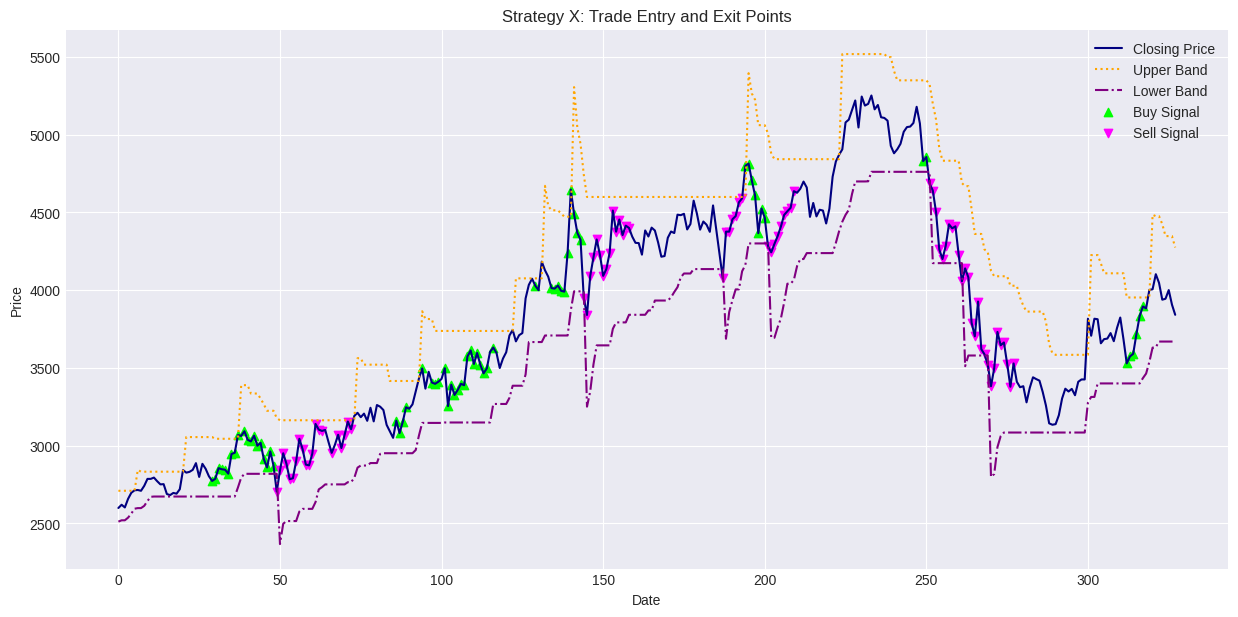

In [96]:
plt.figure(figsize=(15,7))
plt.plot(df['close'], label='Closing Price', color='navy', linestyle='-')
plt.plot(df['upperband'], label='Upper Band', linestyle=':', color='orange')
plt.plot(df['lowerband'], label='Lower Band', linestyle='-.', color='purple')
plt.scatter(df[df['Signal'] == 1].index,
            df[df['Signal'] == 1]['close'],
            marker='^', color='lime', label='Buy Signal')
plt.scatter(df[df['Signal'] == -1].index,
            df[df['Signal'] == -1]['close'],
            marker='v', color='magenta', label='Sell Signal')
plt.title('Strategy X: Trade Entry and Exit Points')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


ATR prevents trades in low-volatility zones where signals are unreliable. Hence it complements Supertrend(trend) and MFI(momentum) with volatility context.

5. Strategy Enhancements:

Identify market regimes (e.g., sideways, choppy, low-volume) where the strategy may underperform or give false signals.
Propose modifications to adapt the strategy for these regimes, considering time-frame sensitivity, indicator tuning, or additional filters.
Ans:

In sideways/choppy market regimes, supertrend may give false flips and also MFI can give wrong signals.
In low-volume periods MFI loses much of its significance and hence singals becomes unreliable.
Proposed modifications:
ATR bases volatility filter : We should not trade when ATR is low. This helps us avoid flat markets.
We can add a trend confirmation EMA filter, in which we go long when EMA is above 200, and short when EMA is below 200. This prevents us in doing countertrend trades.